In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import scipy.stats
from datetime import datetime, date

import sys
sys.path.append('../mchem_functions')
import PCA_functions as pcf
import multivariate_functions as mvf

In [2]:
chosen_PCs = [1,2]
no_of_components = 5

scaling_method = 'standard'

samples_to_exclude = ['SRFA']
vars_to_exclude = ['unassigned','P','Cl','F',]

ms_data_dir = '../../Data/MS_data'
meta_data_csv = 'CSV_files/processed_csv_data_dir/meta_data.csv'
run_order_csv = 'run_order.csv'

In [3]:
try: os.chdir(ms_data_dir)
except FileNotFoundError: pass

In [4]:
meta_data_df = pd.read_csv(meta_data_csv,index_col=0)
sample_names = list(meta_data_df.index)
variables = list(meta_data_df.columns)

In [5]:
for sample in samples_to_exclude:
    for sample2 in [name for name in sample_names if sample in name]:
        sample_names.remove(sample2)

In [6]:
run_order_df = pd.read_csv(run_order_csv)
run_order_df = run_order_df[run_order_df['sample_type']=='sample']
run_order_df = run_order_df.sort_values('sample_name')
seasonsshort = {'10':'Aut','01':'Win1','02':'Win2'}
run_order_df = run_order_df[run_order_df['sample_name'].str.contains('_i_')]
run_order_df['sample_name'] = ['-'.join([x.split('-')[1],x.split('_')[0].split('-')[-4],seasonsshort[x.split('_')[0].split('-')[-2]]]) for x in run_order_df['sample_name']]
run_order_df = run_order_df.reset_index()
for i in range(len(run_order_df)):
    if run_order_df.loc[i]['sample_name'] not in sample_names:
        run_order_df = run_order_df.drop(index=i)

In [21]:
def matr_colormesh(arr,x=[],y=[],cmap='viridis'):
    fig, ax = plt.subplots()

    mappable = ax.pcolormesh(arr,cmap=cmap)
    fig.colorbar(mappable)

    ax.set_ylim(np.max(ax.get_ylim()),np.min(ax.get_ylim()))

    if len(x) != 0:
        locationsx = np.arange(len(x))+0.5
        ax.set_xticks(locationsx, x, rotation=90, ha='center')
    if len(y) != 0:
        locationsy = np.arange(len(y))+0.5
        ax.set_yticks(locationsy, y)

def wetordry(str):
    if str in ([f'HM-{x}' for x in ['A','B','C','D']] + [f'AM-{x}' for x in ['A','B']]):
        return 'dry'
    else: return 'wet'

def add_ticks(ax,axis,mult=.2,no_of_minorticks=1):
    if axis == 'x':
        ax_set_ticks = ax.set_xticks
        lims = ax.get_xlim()
        lims_range = np.max(lims)-np.min(lims)
        set_minor_ticks = ax.xaxis.set_minor_locator
    elif axis == 'y':
        ax_set_ticks = ax.set_yticks
        lims = ax.get_ylim()
        lims_range = np.max(lims)-np.min(lims)
        set_minor_ticks = ax.yaxis.set_minor_locator
        
    step = mult*lims_range
    major_ticks = np.arange(np.min(lims),np.max(lims)+step,step)
    ax_set_ticks(major_ticks)
    set_minor_ticks(AutoMinorLocator(no_of_minorticks+1))

In [8]:
meta_data_df = meta_data_df.loc[sample_names]

for var in vars_to_exclude:
    for var2 in [variable for variable in variables if var in variable]:
        variables.remove(var2)

meta_data_df = meta_data_df[variables]
meta_data_arr = meta_data_df.to_numpy()

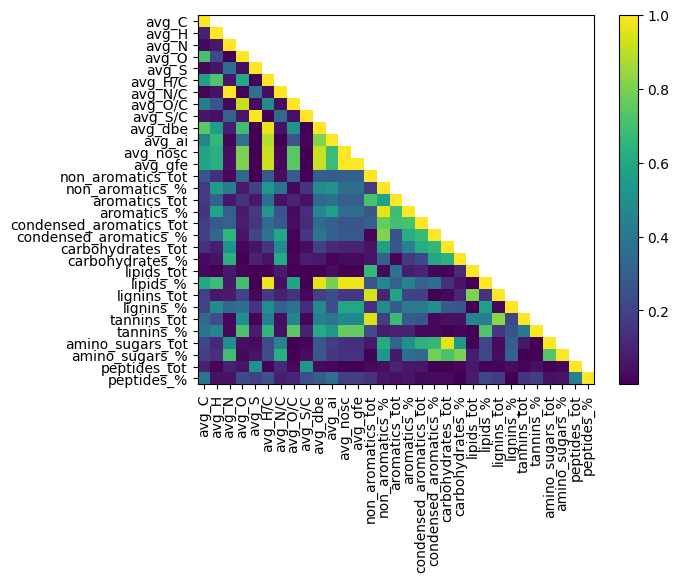

In [9]:
corrs = []
for i in range(np.shape(meta_data_arr)[1]):
    row = []
    for j in range(np.shape(meta_data_arr)[1]):
        row.append((scipy.stats.linregress(meta_data_arr[:,i], meta_data_arr[:,j])[2])**2)
    corrs.append(row)
corrs = np.array(corrs)
tril = np.tril(corrs)
zeroless = np.ma.masked_where(tril == 0, tril)
matr_colormesh(zeroless,x=variables,y=variables)

In [10]:
# choose variables depending on redundancy of information to avoid double counting
vars_to_exclude += ['_tot','ai']

In [11]:
for var in vars_to_exclude:
    for var2 in [variable for variable in variables if var in variable]:
        variables.remove(var2)

meta_data_df = meta_data_df[variables]

meta_data_arr = meta_data_df.to_numpy()

abbr = ['ai','dbe','gfe','nosc']
for i in range(len(variables)):
    v = variables[i]
    
    for a in abbr: v = v.replace(a.lower(),a.upper())
    v = v.replace('_',' ').replace('avg','average').replace(' %',' (%)')

    v = v[0].upper() + v[1:]

    variables[i] = v

# variables

In [12]:
# pd.DataFrame(meta_data_arr)

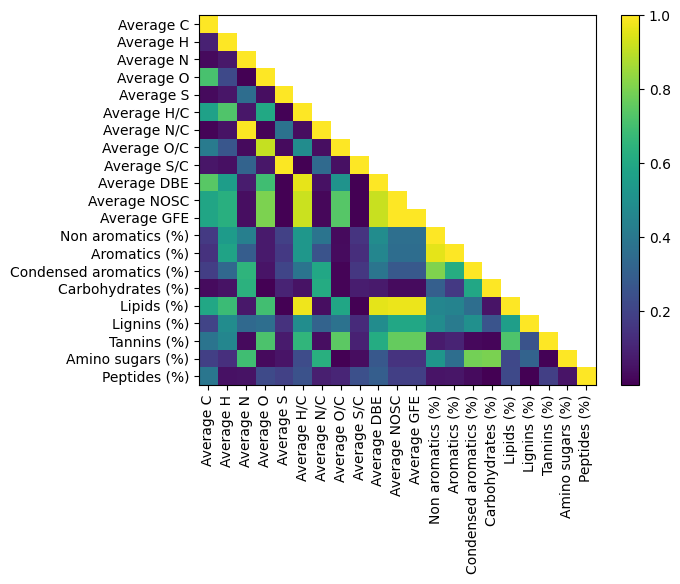

In [13]:
corrs = []
for i in range(np.shape(meta_data_arr)[1]):
    row = []
    for j in range(np.shape(meta_data_arr)[1]):
        row.append((scipy.stats.linregress(meta_data_arr[:,i], meta_data_arr[:,j])[2])**2)
    corrs.append(row)
corrs = np.array(corrs)
tril = np.tril(corrs)
zeroless = np.ma.masked_where(tril == 0, tril)
matr_colormesh(zeroless)
ax = plt.gca()

locationsx = np.arange(len(variables))+0.5
locationsy = np.arange(len(variables))+0.5
ax.set_xticks(locationsx, variables, rotation = 90)
ax.set_yticks(locationsy, variables)

In [14]:
sample_info = {
    'Site': [],
    'Letter': [],
    'Season': [],
    'Type': [],
    'Wetness':[]
}

for name in sample_names:
    if 'SRFA' in name.upper():
        for key in sample_info:
            if key == 'Type': sample_info[key].append('SRFA')
            else: sample_info[key].append('NA')

    else:
        name = name.split('-')
        sample_info['Site'].append(name[0])
        sample_info['Letter'].append(name[1])
        sample_info['Season'].append(name[2])
        if 'PL' in name: sample_info['Type'].append('PL')
        else: sample_info['Type'].append('PW')
        sample_info['Wetness'].append(wetordry('-'.join(name[:-1])))

for info in sample_info:
    sample_info[info] = np.array(sample_info[info])
# sample_info

In [15]:
scores_values, variance_ratio, PCs, loadings = pcf.get_pca_data(meta_data_arr,no_of_components,scaling_method)

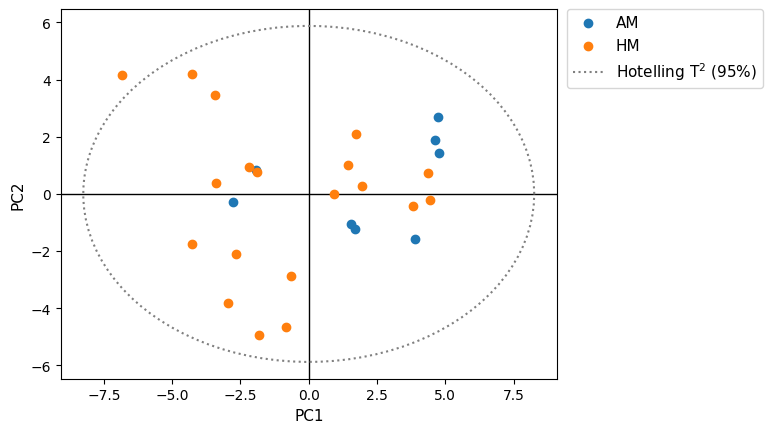

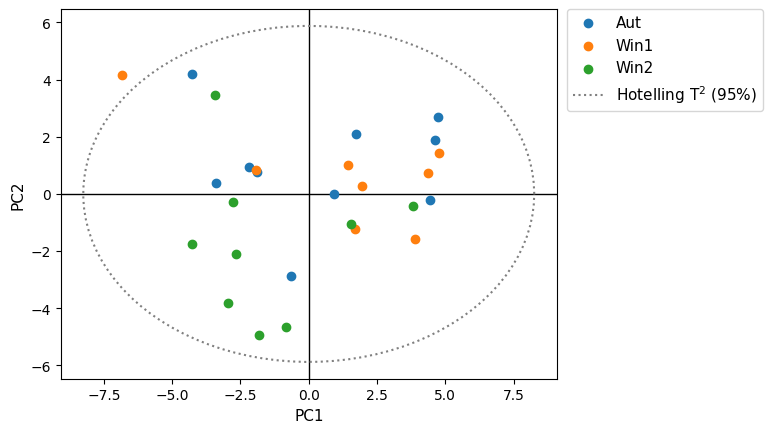

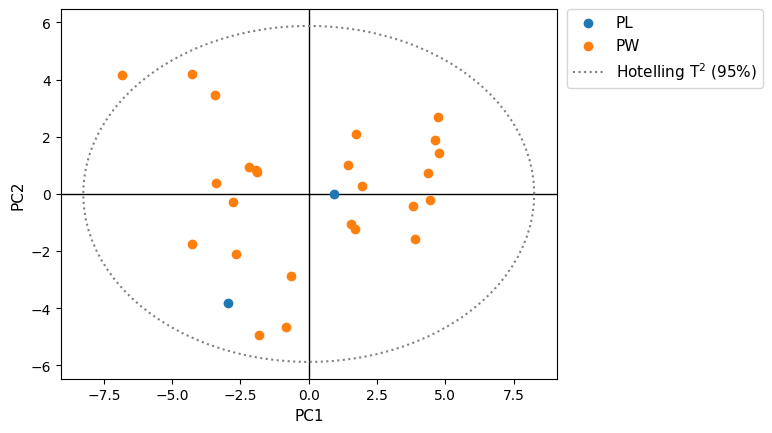

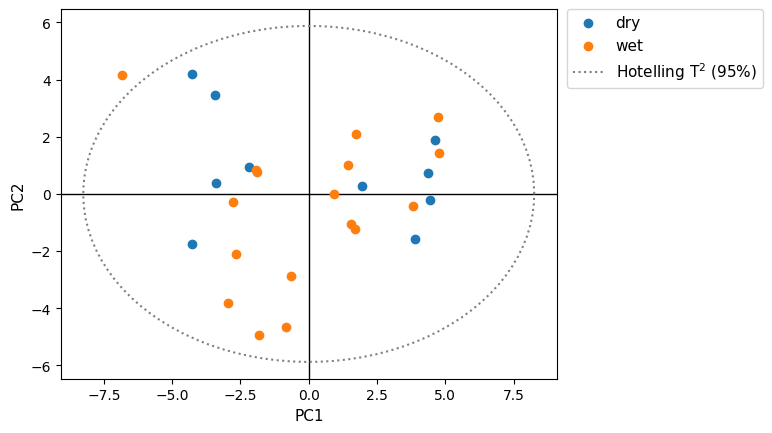

In [16]:
chosen_info = []
if chosen_info in [None,[],[None]]:
    chosen_info = list(sample_info.keys())
    if 'Letter' in chosen_info: chosen_info.remove('Letter')

for info in chosen_info:
    unique_info = np.unique(sample_info[info])

    fig_scores, ax_scores = plt.subplots()
    
    for u in unique_info:
        idx = np.where(sample_info[info] == u)
        pcf.scores_plot(scores_values[idx],chosen_PCs,lines=False,ax=ax_scores,label=u)
    
    pcf.Hotelling(scores_values,chosen_PCs,ax_scores)

    ax_scores.set_title('',fontsize=15)
    ax_scores.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
    ax_scores.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)

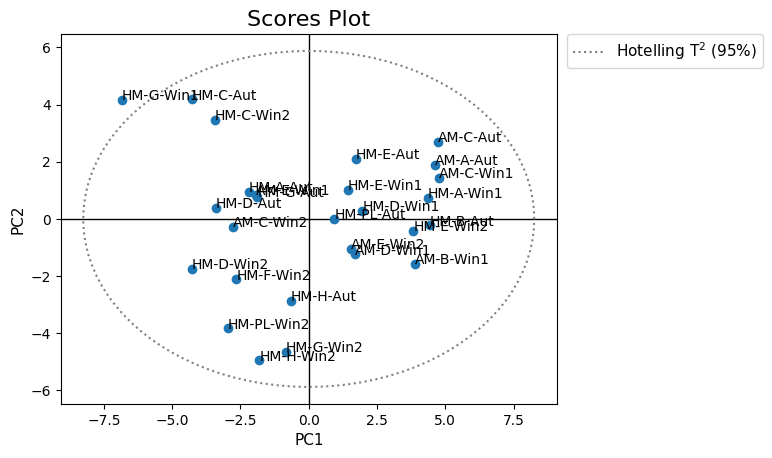

In [17]:
pcf.scores_plot(scores_values,chosen_PCs)
pcf.Hotelling(scores_values,chosen_PCs,plt.gca())
for i in range(len(sample_names)):
    plt.text(scores_values[i,chosen_PCs[0]-1],scores_values[i,chosen_PCs[1]-1],sample_names[i])

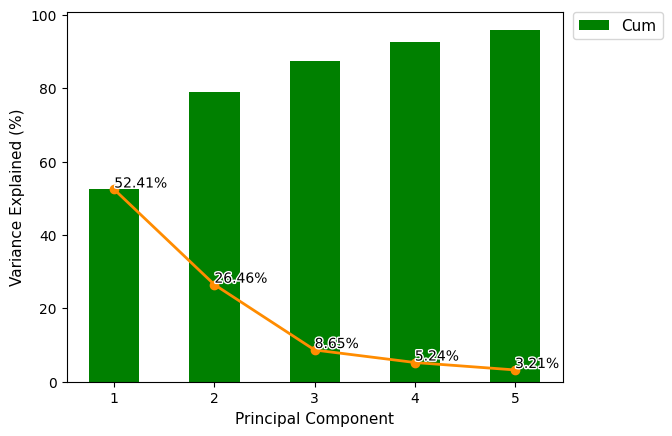

In [18]:
pcf.scree_plot(PCs,variance_ratio,title='',save_path=f'plots/pca_plots/scree_plot.svg')

In [19]:
loadings_chosen_PCs = [1,2]

In [20]:
def addlike(string):
    if '-like' not in string:
        for comp in ['Carbohydrate','Lipid','Lignin','Tannin','Amino sugar','Peptide']:
            if comp in string: string = string.replace(f'{comp}s',f'{comp}-like')
    return string
variables = [addlike(x) for x in variables]

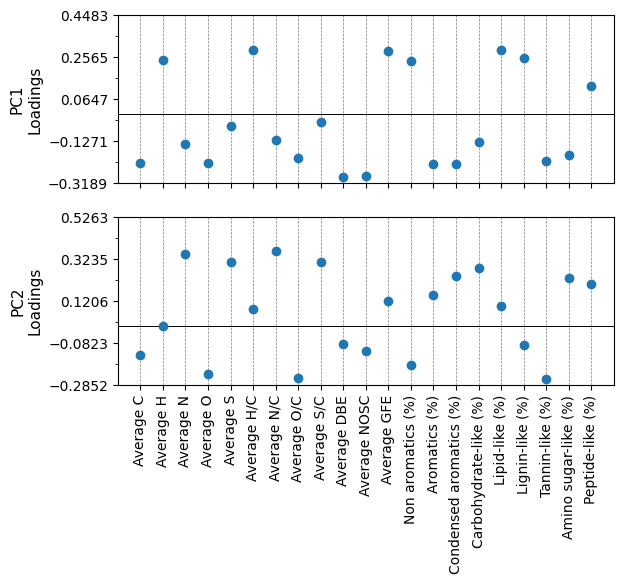

In [24]:
fig_loadings = plt.figure()
ax_loadings = fig_loadings.subplots(len(loadings_chosen_PCs),sharex=True)

pcf.loadings_plot(variables,loadings.T,loadings_chosen_PCs,text_rotation=90,linestyle='',marker='o',ax=ax_loadings,fig=fig_loadings,
                  title='')

for ax in ax_loadings:
    for i in range(len(variables)):
        ax.axvline(i,ls='--',lw=.5,c='gray',zorder=-1)
# for i in range(len(variables)):
#     ax_loadings.axvline(i,ls='--',lw=.5,c='gray',zorder=-1)
for ax in ax_loadings:
    add_ticks(ax,'y',mult=.3)
fig_loadings.savefig(f'plots/pca_plots/loadings_plots.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

In [26]:
m_shape = {
    'Hare Moss': 'o',
    'Auchencorth Moss': 's',
}

seasonal_colours = {
    'Aut': '#BF5700', # burnt orange
    'Win1': '#4B61D1', # Savoy blue
    'Win2': '#4E2A84', # northwestern purple
    'Spr': '#E0B0FF', # mauve
    'Sum': '#50C878', # emerald green
}

wetordry_colours = {
    'wet': 'blue',
    'dry': 'orange'
}

In [27]:
sitelong = [{'AM':'Auchencorth Moss','HM':'Hare Moss'}[site] for site in sample_info['Site']]
sample_info['sitelong'] = np.array(sitelong)
sample_info['date'] = run_order_df['date'].to_numpy()

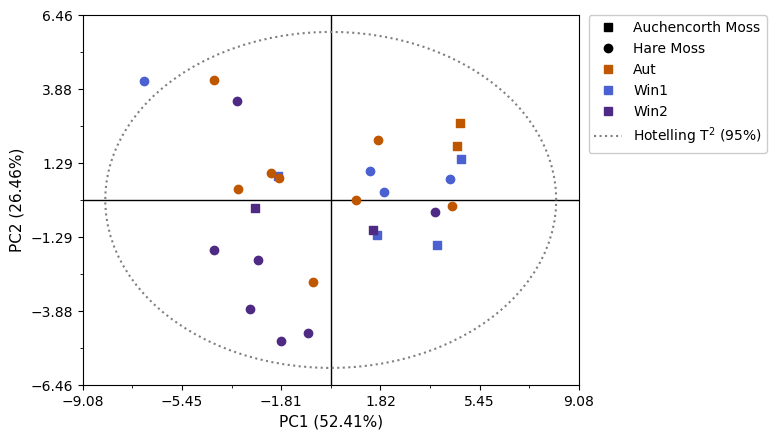

In [28]:
fig_scores, ax_scores = plt.subplots()

for site in np.unique(sample_info['sitelong']):
    for season in np.unique(sample_info['Season']):

        idx = np.where((sample_info['sitelong'] == site)&(sample_info['Season'] == season))

        pcf.scores_plot(scores_values[idx],chosen_PCs,lines=False,ax=ax_scores,
                        marker=m_shape[site],c=seasonal_colours[season],variance_ratio=variance_ratio)
        
pcf.Hotelling(scores_values,chosen_PCs,ax_scores)

title = f'Scores Plot of the Elemental Indices by Site and Season'
ax_scores.set_title('',fontsize=15)
ax_scores.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)

# Adapted from https://stackoverflow.com/questions/45140295/how-to-create-a-legend-of-both-color-and-marker
f = lambda m,c,ls: ax_scores.plot([],[],marker=m, color=c, ls=ls)[0]
handles = []
labels  = []
for site in np.unique(sample_info['sitelong']):
    handles.append(f(m_shape[site], "k", ls="none"))
    labels.append(site)
for season in np.unique(sample_info['Season']):
    handles.append(f('s', seasonal_colours[season],ls="none"))
    labels.append(season)

handles += [f('none', "grey",ls=":")]
labels += ['Hotelling T$^{2}$ (95%)']
ax_scores.legend(handles, labels, framealpha=1,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
add_ticks(ax_scores,'x')
add_ticks(ax_scores,'y')
fig_scores.savefig(f'plots/pca_plots/ms_pca_scores.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

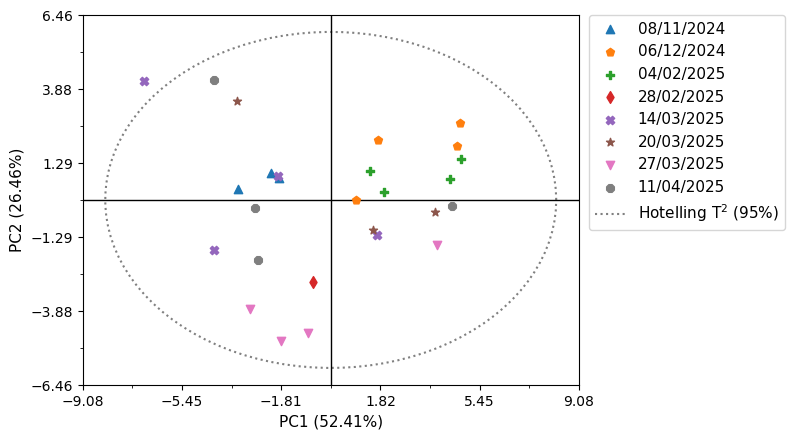

In [29]:
fig_scores, ax_scores = plt.subplots()
sorted_dates = sorted(np.unique(sample_info['date']), key=lambda x: datetime.strptime(x, '%d/%m/%Y'))
datemarkers = ['^','p','P','d','X','*','v','8']
for i in range(len(sorted_dates)):
    idx = np.where((sample_info['date'] == sorted_dates[i]))
    pcf.scores_plot(scores_values[idx],chosen_PCs,lines=False,ax=ax_scores,label=sorted_dates[i],
                    marker=datemarkers[i],variance_ratio=variance_ratio)

ax_scores.set_title('',fontsize=15)
pcf.Hotelling(scores_values,chosen_PCs,ax_scores,zorder=-1)
ax_scores.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)
add_ticks(ax_scores,'x')
add_ticks(ax_scores,'y')
fig_scores.savefig('plots/pca_plots/scores_bydate.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

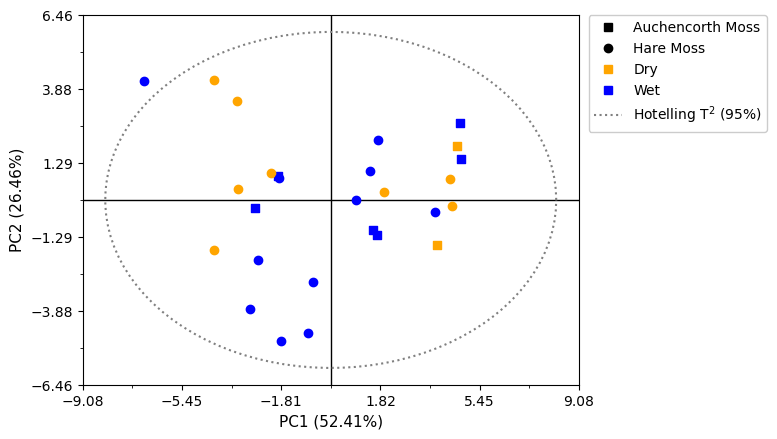

In [30]:
fig_scores, ax_scores = plt.subplots()

for site in np.unique(sample_info['sitelong']):
    for wod in np.unique(sample_info['Wetness']):

        idx = np.where((sample_info['sitelong'] == site)&(sample_info['Wetness'] == wod))

        pcf.scores_plot(scores_values[idx],chosen_PCs,lines=False,ax=ax_scores,
                        marker=m_shape[site],c=wetordry_colours[wod],variance_ratio=variance_ratio)
        
pcf.Hotelling(scores_values,chosen_PCs,ax_scores)

title = f'Scores Plot of the Elemental Indices by Site and Wetness'
ax_scores.set_title('',fontsize=15)
ax_scores.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)

# Adapted from https://stackoverflow.com/questions/45140295/how-to-create-a-legend-of-both-color-and-marker
f = lambda m,c,ls: ax_scores.plot([],[],marker=m, color=c, ls=ls)[0]
handles = []
labels  = []
for site in np.unique(sample_info['sitelong']):
    handles.append(f(m_shape[site], "k", ls="none"))
    labels.append(site)
for wod in np.unique(sample_info['Wetness']):
    handles.append(f('s', wetordry_colours[wod],ls="none"))
    labels.append(wod.capitalize())

handles += [f('none', "grey",ls=":")]
labels += ['Hotelling T$^{2}$ (95%)']
ax_scores.legend(handles, labels, framealpha=1,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
add_ticks(ax_scores,'x')
add_ticks(ax_scores,'y')
fig_scores.savefig(f'plots/pca_plots/ms_pca_scores_wetness.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

PCA by individual site

In [31]:
meta_data_arr_HM = meta_data_arr[np.where(sample_info['Site'] == 'HM')]
seasons_HM = np.array([x.split('-')[-1] for x in sample_names if x.startswith('HM-')])
meta_data_arr_AM = meta_data_arr[np.where(sample_info['Site'] == 'AM')]
seasons_AM = np.array([x.split('-')[-1] for x in sample_names if x.startswith('AM-')])

# remove all zeros
idx_2remove_AM = np.argwhere(np.all(meta_data_arr_AM[..., :] == 0, axis=0))
meta_data_arr_AM = np.delete(meta_data_arr_AM, idx_2remove_AM, axis=1)
variables_AM = np.delete(variables,idx_2remove_AM)
idx_2remove_HM = np.argwhere(np.all(meta_data_arr_HM[..., :] == 0, axis=0))
meta_data_arr_HM = np.delete(meta_data_arr_HM, idx_2remove_HM, axis=1)
variables_HM = np.delete(variables,idx_2remove_HM)

In [32]:
HM_PCs = np.min([len(meta_data_arr_HM),no_of_components])
AM_PCs = np.min([len(meta_data_arr_AM),no_of_components])

scores_values_HM, variance_ratio_HM, PCs_HM, loadings_HM = pcf.get_pca_data(meta_data_arr_HM,HM_PCs,scaling_method)
scores_values_AM, variance_ratio_AM, PCs_AM, loadings_AM = pcf.get_pca_data(meta_data_arr_AM,AM_PCs,scaling_method)

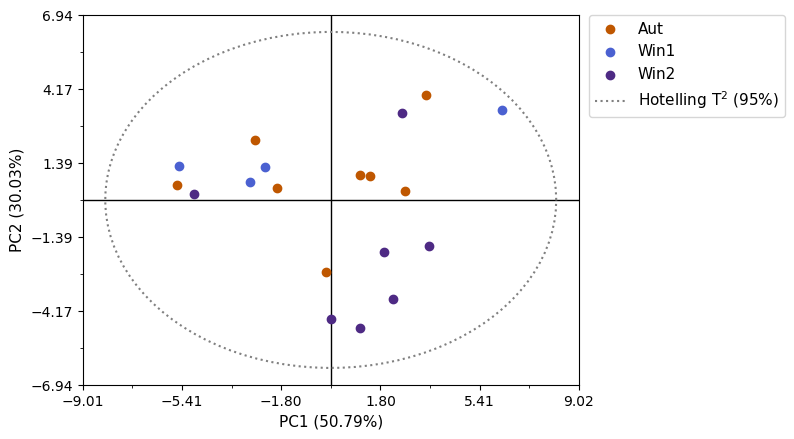

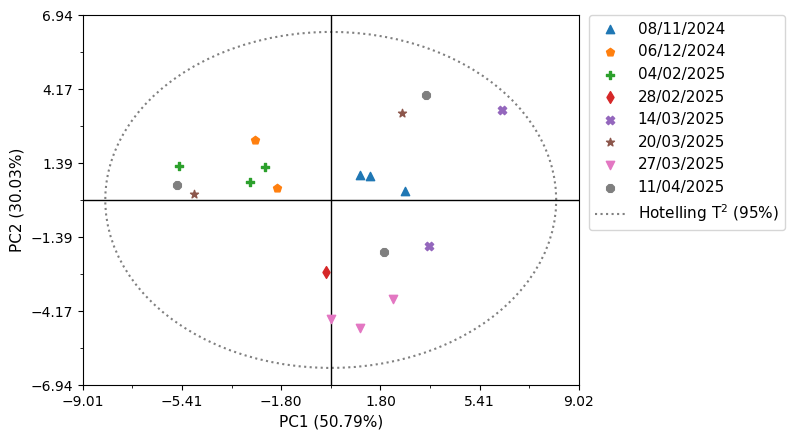

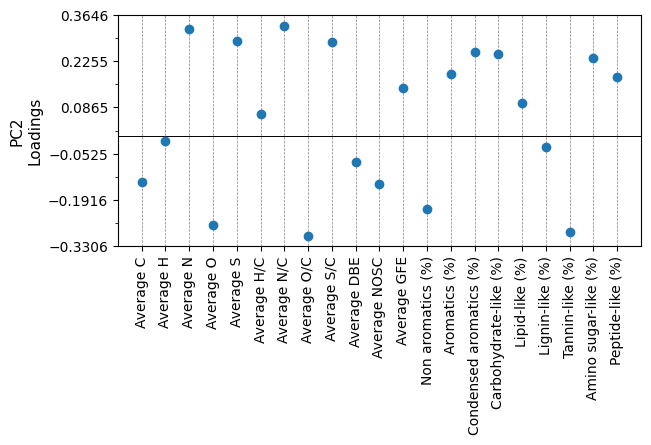

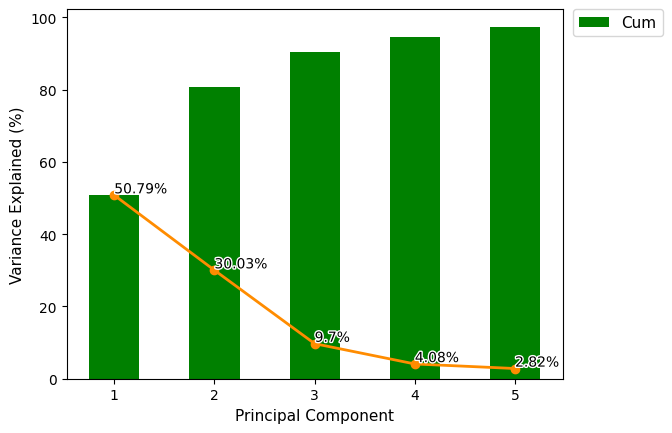

In [35]:
fig_scores, ax_scores = plt.subplots()

for season in np.unique(seasons_HM):

    idx = np.where(seasons_HM == season)

    pcf.scores_plot(scores_values_HM[idx],chosen_PCs,lines=False,ax=ax_scores,marker=m_shape['Hare Moss'],
                    c=seasonal_colours[season],label=season,variance_ratio=variance_ratio_HM)
        
pcf.Hotelling(scores_values_HM,chosen_PCs,ax_scores)

ax_scores.set_title('',fontsize=15)
ax_scores.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)
add_ticks(ax_scores,'x')
add_ticks(ax_scores,'y')
fig_scores.savefig(f'plots/pca_plots/hm_scores_plot_of_the_elemental_indices.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

#---
fig_scores, ax_scores = plt.subplots()
for i in range(len(sorted_dates)):
    idx = np.where((sample_info['date'][np.where(sample_info['Site'] == 'HM')] == sorted_dates[i]))
    pcf.scores_plot(scores_values_HM[idx],chosen_PCs,lines=False,ax=ax_scores,
                    label=sorted_dates[i],marker=datemarkers[i],variance_ratio=variance_ratio_HM)

ax_scores.set_title('',fontsize=15)
pcf.Hotelling(scores_values_HM,chosen_PCs,ax_scores,zorder=-1)
ax_scores.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)
add_ticks(ax_scores,'x')
add_ticks(ax_scores,'y')
fig_scores.savefig('plots/pca_plots/hm_scores_bydate.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

#---
loadings_chosen_PCs = [2]
fig_loadings = plt.figure(figsize=(6.75,3))
ax_loadings = fig_loadings.subplots(len(loadings_chosen_PCs),sharex=True)

pcf.loadings_plot(variables_HM,loadings_HM.T,loadings_chosen_PCs,text_rotation=90,linestyle='',
                  marker='o',ax=ax_loadings,title='',fig=fig_loadings)

for i in range(len(variables_HM)):
    ax_loadings.axvline(i,ls='--',lw=.5,c='gray',zorder=-1)

add_ticks(ax_loadings,'y')
fig_loadings.savefig(f'plots/pca_plots/hm_loadings_plots.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

#---

pcf.scree_plot(PCs_HM,variance_ratio_HM,title='',save_path=f'plots/pca_plots/hm_scree_plot.svg')

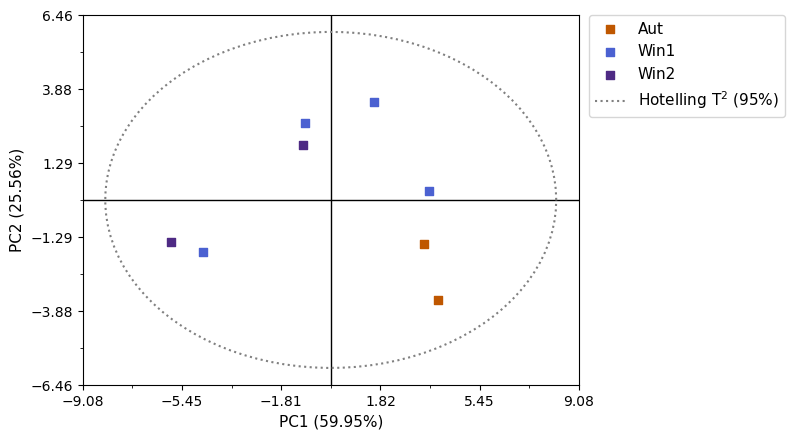

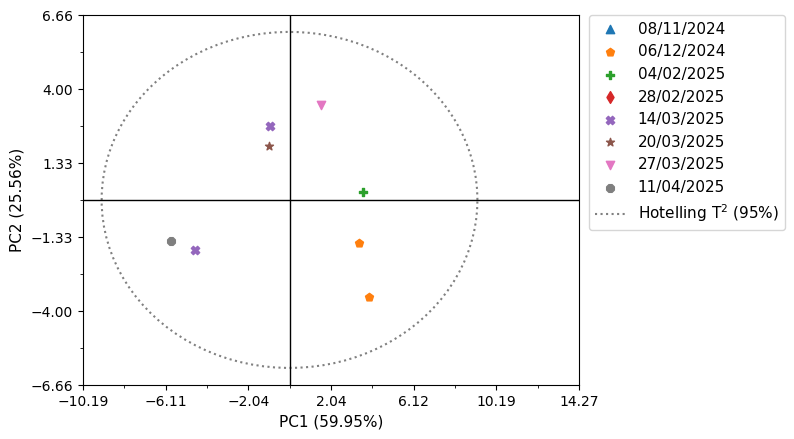

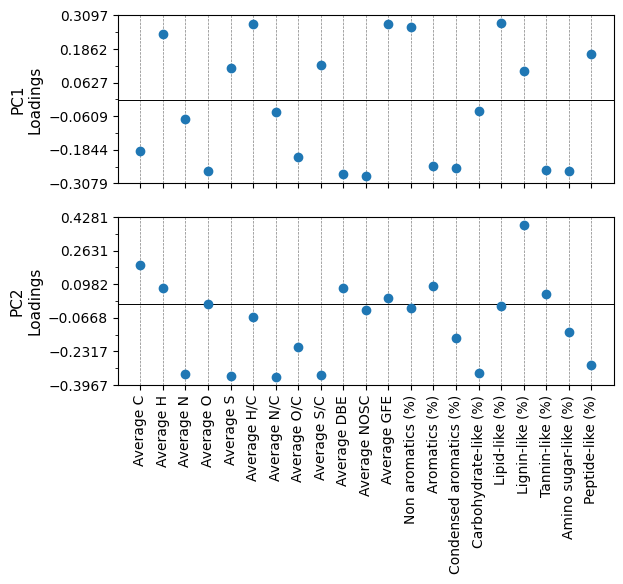

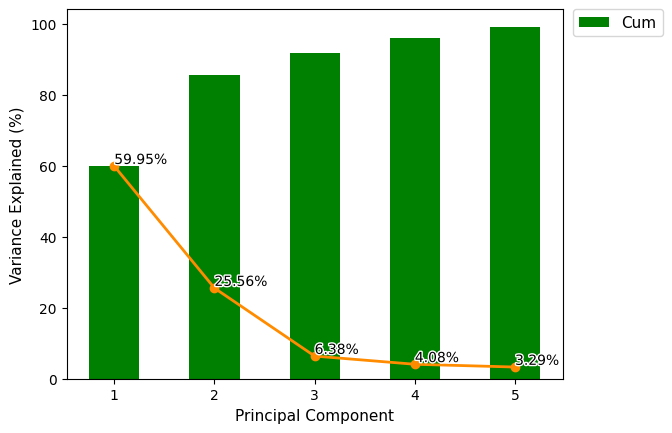

In [37]:
fig_scores, ax_scores = plt.subplots()

for season in np.unique(seasons_AM):

    idx = np.where(seasons_AM == season)

    pcf.scores_plot(scores_values_AM[idx],chosen_PCs,lines=False,ax=ax_scores,marker=m_shape['Auchencorth Moss'],
                    c=seasonal_colours[season],label=season,variance_ratio=variance_ratio_AM)
        
pcf.Hotelling(scores_values,chosen_PCs,ax_scores)

ax_scores.set_title('',fontsize=15)
ax_scores.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)
add_ticks(ax_scores,'x')
add_ticks(ax_scores,'y')
fig_scores.savefig(f'plots/pca_plots/am_scores_plot_of_the_elemental_indices.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

#---
fig_scores, ax_scores = plt.subplots()
for i in range(len(sorted_dates)):
    idx = np.where((sample_info['date'][np.where(sample_info['Site'] == 'AM')] == sorted_dates[i]))
    pcf.scores_plot(scores_values_AM[idx],chosen_PCs,lines=False,ax=ax_scores,
                    label=sorted_dates[i],marker=datemarkers[i],variance_ratio=variance_ratio_AM)

ax_scores.set_title('',fontsize=15)
pcf.Hotelling(scores_values_AM,chosen_PCs,ax_scores,zorder=-1)
ax_scores.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)
add_ticks(ax_scores,'x')
add_ticks(ax_scores,'y')
fig_scores.savefig('plots/pca_plots/am_scores_bydate.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

#---

fig_loadings = plt.figure()
ax_loadings = fig_loadings.subplots(len(chosen_PCs),sharex=True)

pcf.loadings_plot(variables_AM,loadings_AM.T,chosen_PCs,text_rotation=90,linestyle='',
                  marker='o',ax=ax_loadings,title='',fig=fig_loadings)

for ax in ax_loadings:
    for i in range(len(variables_AM)):
        ax.axvline(i,ls='--',lw=.5,c='gray',zorder=-1)
for ax in ax_loadings:
    add_ticks(ax,'y')
fig_loadings.savefig(f'plots/pca_plots/am_loadings_plots.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

#---

pcf.scree_plot(PCs_AM,variance_ratio_AM,title='',save_path=f'plots/pca_plots/am_scree_plot.svg')
